# Novelty

In [1]:
from koselleck import *

In [15]:
def do_get_novelty(word,**kwargs):
    return test_novelty(get_historical_semantic_distance_matrix(
            word,
            interpolate=True,
            normalize=True
        ),
        **kwargs
    ).assign(word=word)

def get_novelty(words=None,interpolate=True,by_word=True,progress=False, lim=None, num_proc=1, **y):
    if words is None: words=get_valid_words()
    words=tokenize_fast(words) if type(words)==str else words
    if os.path.exists(FN_NOV_ALL_BYWORD):
        odf=get_all_novelty_scores(by_foote_size=True)
        odf=odf[odf.word.isin(words)]
        if not by_word: odf=odf.groupby(['foote_size','period']).mean().reset_index()
    else:
        if by_word:
            o=pmap(
                do_get_novelty,
                words[:lim],
                progress=progress,
                desc='Calculating novelty for words',
                num_proc=num_proc
            )
            odf=pd.concat(o) if len(o) else pd.DataFrame()
        else:
            distdf=get_historical_semantic_distance_matrix(words,interpolate=interpolate)
            odf=test_novelty(distdf,**y)
        odf['period']=[int(x[:4]) for x in odf.period]
    return odf

In [36]:
def get_all_novelty_scores(ifnfn=FN_NOV_ALL_BYWORD,
                           by_foote_size=False, min_foote_size=6, max_foote_size=6):
    global DFALLNOV
    if DFALLNOV is not None:
        odf=DFALLNOV
    elif not os.path.exists(ifnfn):
        print(f'Generating novelty scores, saving to {ifnfn}')
        DFALLNOV = odf = nov_all_byword = get_novelty(by_word=True,progress=True,num_proc=1)
        nov_all_byword.to_pickle(FN_NOV_ALL_BYWORD)
    else:
        print(f'Loading novelty scores from {ifnfn}')
        with open(ifnfn,'rb') as f: odf=pickle.load(f)
        DFALLNOV=odf
        
    odf = odf.query(f'foote_novelty!=0 & {min_foote_size}<=foote_size<={max_foote_size}')
    odf = pd.concat(
        grp.assign(
            foote_novelty_z=(grp.foote_novelty - grp.foote_novelty.mean()) / grp.foote_novelty.std()
        )
        for i,grp in odf.groupby('foote_size')
    )
    if not by_foote_size:
        odf=odf.groupby(['word','period']).mean().drop('foote_size',1).reset_index()
    else:
        odf['foote_size']=odf.foote_size.apply(int)
        
    #odf=odf.query('period<1900')
    return odf
        


In [37]:
get_novelty('virtue,value',by_word=True)

,period,foote_novelty,foote_size,p_peak,p_trough,word,foote_novelty_z
198,1750,13.044071,6,0.15,1.0,value,0.637107
199,1755,12.663455,6,0.18,1.0,value,0.570311
200,1760,11.540439,6,0.39,1.0,value,0.373227
201,1765,8.401534,6,0.98,1.0,value,-0.177636
202,1770,8.035269,6,1.00,1.0,value,-0.241914
...,...,...,...,...,...,...,...
229,1905,8.042206,6,0.57,1.0,virtue,-0.240696
230,1910,10.422168,6,0.02,1.0,virtue,0.176976
231,1915,9.391275,6,0.15,1.0,virtue,-0.003941
232,1920,8.446556,6,0.46,1.0,virtue,-0.169735


In [38]:
# get_novelty('station', by_word=False).query('foote_novelty!=0')

In [39]:
# nov_all_mean=get_novelty(by_word=False)
# nov_all_mean

In [40]:
get_all_novelty_scores(by_foote_size=True)

,period,foote_novelty,foote_size,p_peak,p_trough,word,foote_novelty_z
178,1775,10.381258,6,0.73,1.0,recollection,0.169796
179,1780,9.245102,6,0.95,1.0,recollection,-0.029594
180,1785,13.390090,6,0.15,1.0,recollection,0.697832
181,1790,15.050656,6,0.02,1.0,recollection,0.989253
182,1795,19.361489,6,0.00,1.0,recollection,1.745784
...,...,...,...,...,...,...,...
224,1905,12.817505,6,0.37,1.0,inference,0.597346
225,1910,12.671342,6,0.41,1.0,inference,0.571695
226,1915,13.574138,6,0.24,1.0,inference,0.730131
227,1920,14.853950,6,0.07,1.0,inference,0.954732


In [41]:
def get_signif_novelty_scores(p_peak=0.05,min_peaks=1):
    odf=get_all_novelty_scores().query(f'p_peak<{p_peak}')
    odf=pd.concat(
        grp.assign(
            word_num_peaks=len(grp[grp.p_peak<p_peak])
        ) for i,grp in odf.groupby('word')
    )
    if min_peaks: odf=odf[odf.word_num_peaks>=min_peaks]
    return odf.sort_values('foote_novelty_z',ascending=False)

In [42]:
get_signif_novelty_scores(
    p_peak=0.05
).groupby('word').mean().sort_values('foote_novelty_z',ascending=False)

,period,foote_novelty,p_peak,p_trough,foote_novelty_z,word_num_peaks
word,,,,,,
slate,1812.5,45.025464,0.00,1.0,6.249689,4.0
tie,1920.0,44.745008,0.00,1.0,6.200471,3.0
fee,1815.0,44.468186,0.00,1.0,6.151890,3.0
regent,1825.0,44.021718,0.00,1.0,6.073537,3.0
crystal,1875.0,43.024960,0.00,1.0,5.898611,5.0
...,...,...,...,...,...,...
part,1750.0,3.799115,0.00,1.0,-0.985339,1.0
occasion,1750.0,3.594143,0.00,1.0,-1.021310,1.0
world,1750.0,3.550242,0.01,1.0,-1.029015,1.0


In [43]:
def get_signif_novelty_words(p_peak=0.05,min_peaks=1):
    df=get_all_novelty_scores()
    dfsign=get_signif_novelty_scores(p_peak=p_peak,min_peaks=min_peaks)
    signwset=set(dfsign.word)
    o=[
        w for w in 
        df.groupby('word').mean().sort_values('foote_novelty',ascending=False).index
        if w in signwset
    ]
    print('# all words',len(set(df.word)))
    print('# signif words',len(set(dfsign.word)))
    return o

In [44]:
sign_words = get_signif_novelty_words(p_peak=0.05)
print(len(sign_words), sign_words[:5])

# all words 5980
# signif words 3008
3008 ['ballroom', 'crepe', 'manufacturer', 'syllabus', 'speciality']


## Plotting

## Plotting all significant words' novelties

In [69]:
def plot_novelty_by_foote_size(p_peak=0.01,min_peaks=1,rolling=2, ymin=-1, nudge_x=1, labsize=6,words={}):
    df=get_all_novelty_scores(by_foote_size=True, min_foote_size=4, max_foote_size=6)
    if not words: words=get_signif_novelty_words(p_peak=p_peak,min_peaks=min_peaks)
#     words={w for w in words if not 's' in w and not 'f' in w}
    print('# words used:',len(words))
    if words: df=df[df.word.isin(words)]
    figdf=pd.DataFrame([
        {
            'foote_size':fs,
            'period':period,
            'num_peaks':len(grp.query(f'p_peak<{p_peak}')),
            'avg_nov_signif':grp.query(f'p_peak<{p_peak}').foote_novelty_z.mean(),
            'avg_nov':grp.foote_novelty_z.mean(),
        } for ((fs,period),grp) in df.groupby([
            'foote_size','period'
        ])
    ])
    for ycol in ['avg_nov','avg_nov_signif']:
        figdf[ycol]=figdf[ycol].rolling(rolling,min_periods=1).mean()
    
    fig=start_fig(
        figdf,
        x='period',
        y='num_peaks',
#         size='num_peaks',
        color='factor(foote_size)',
#         linetype='factor(foote_size)',
    )
    fig+=p9.geom_line()
    fig+=p9.geom_point(p9.aes(shape='factor(foote_size)'))
    
    fig+=p9.scale_color_gray(start=.8, end=.2)
    fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0))
    fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    return fig

# all words 5980
# signif words 2107
# words used: 2107


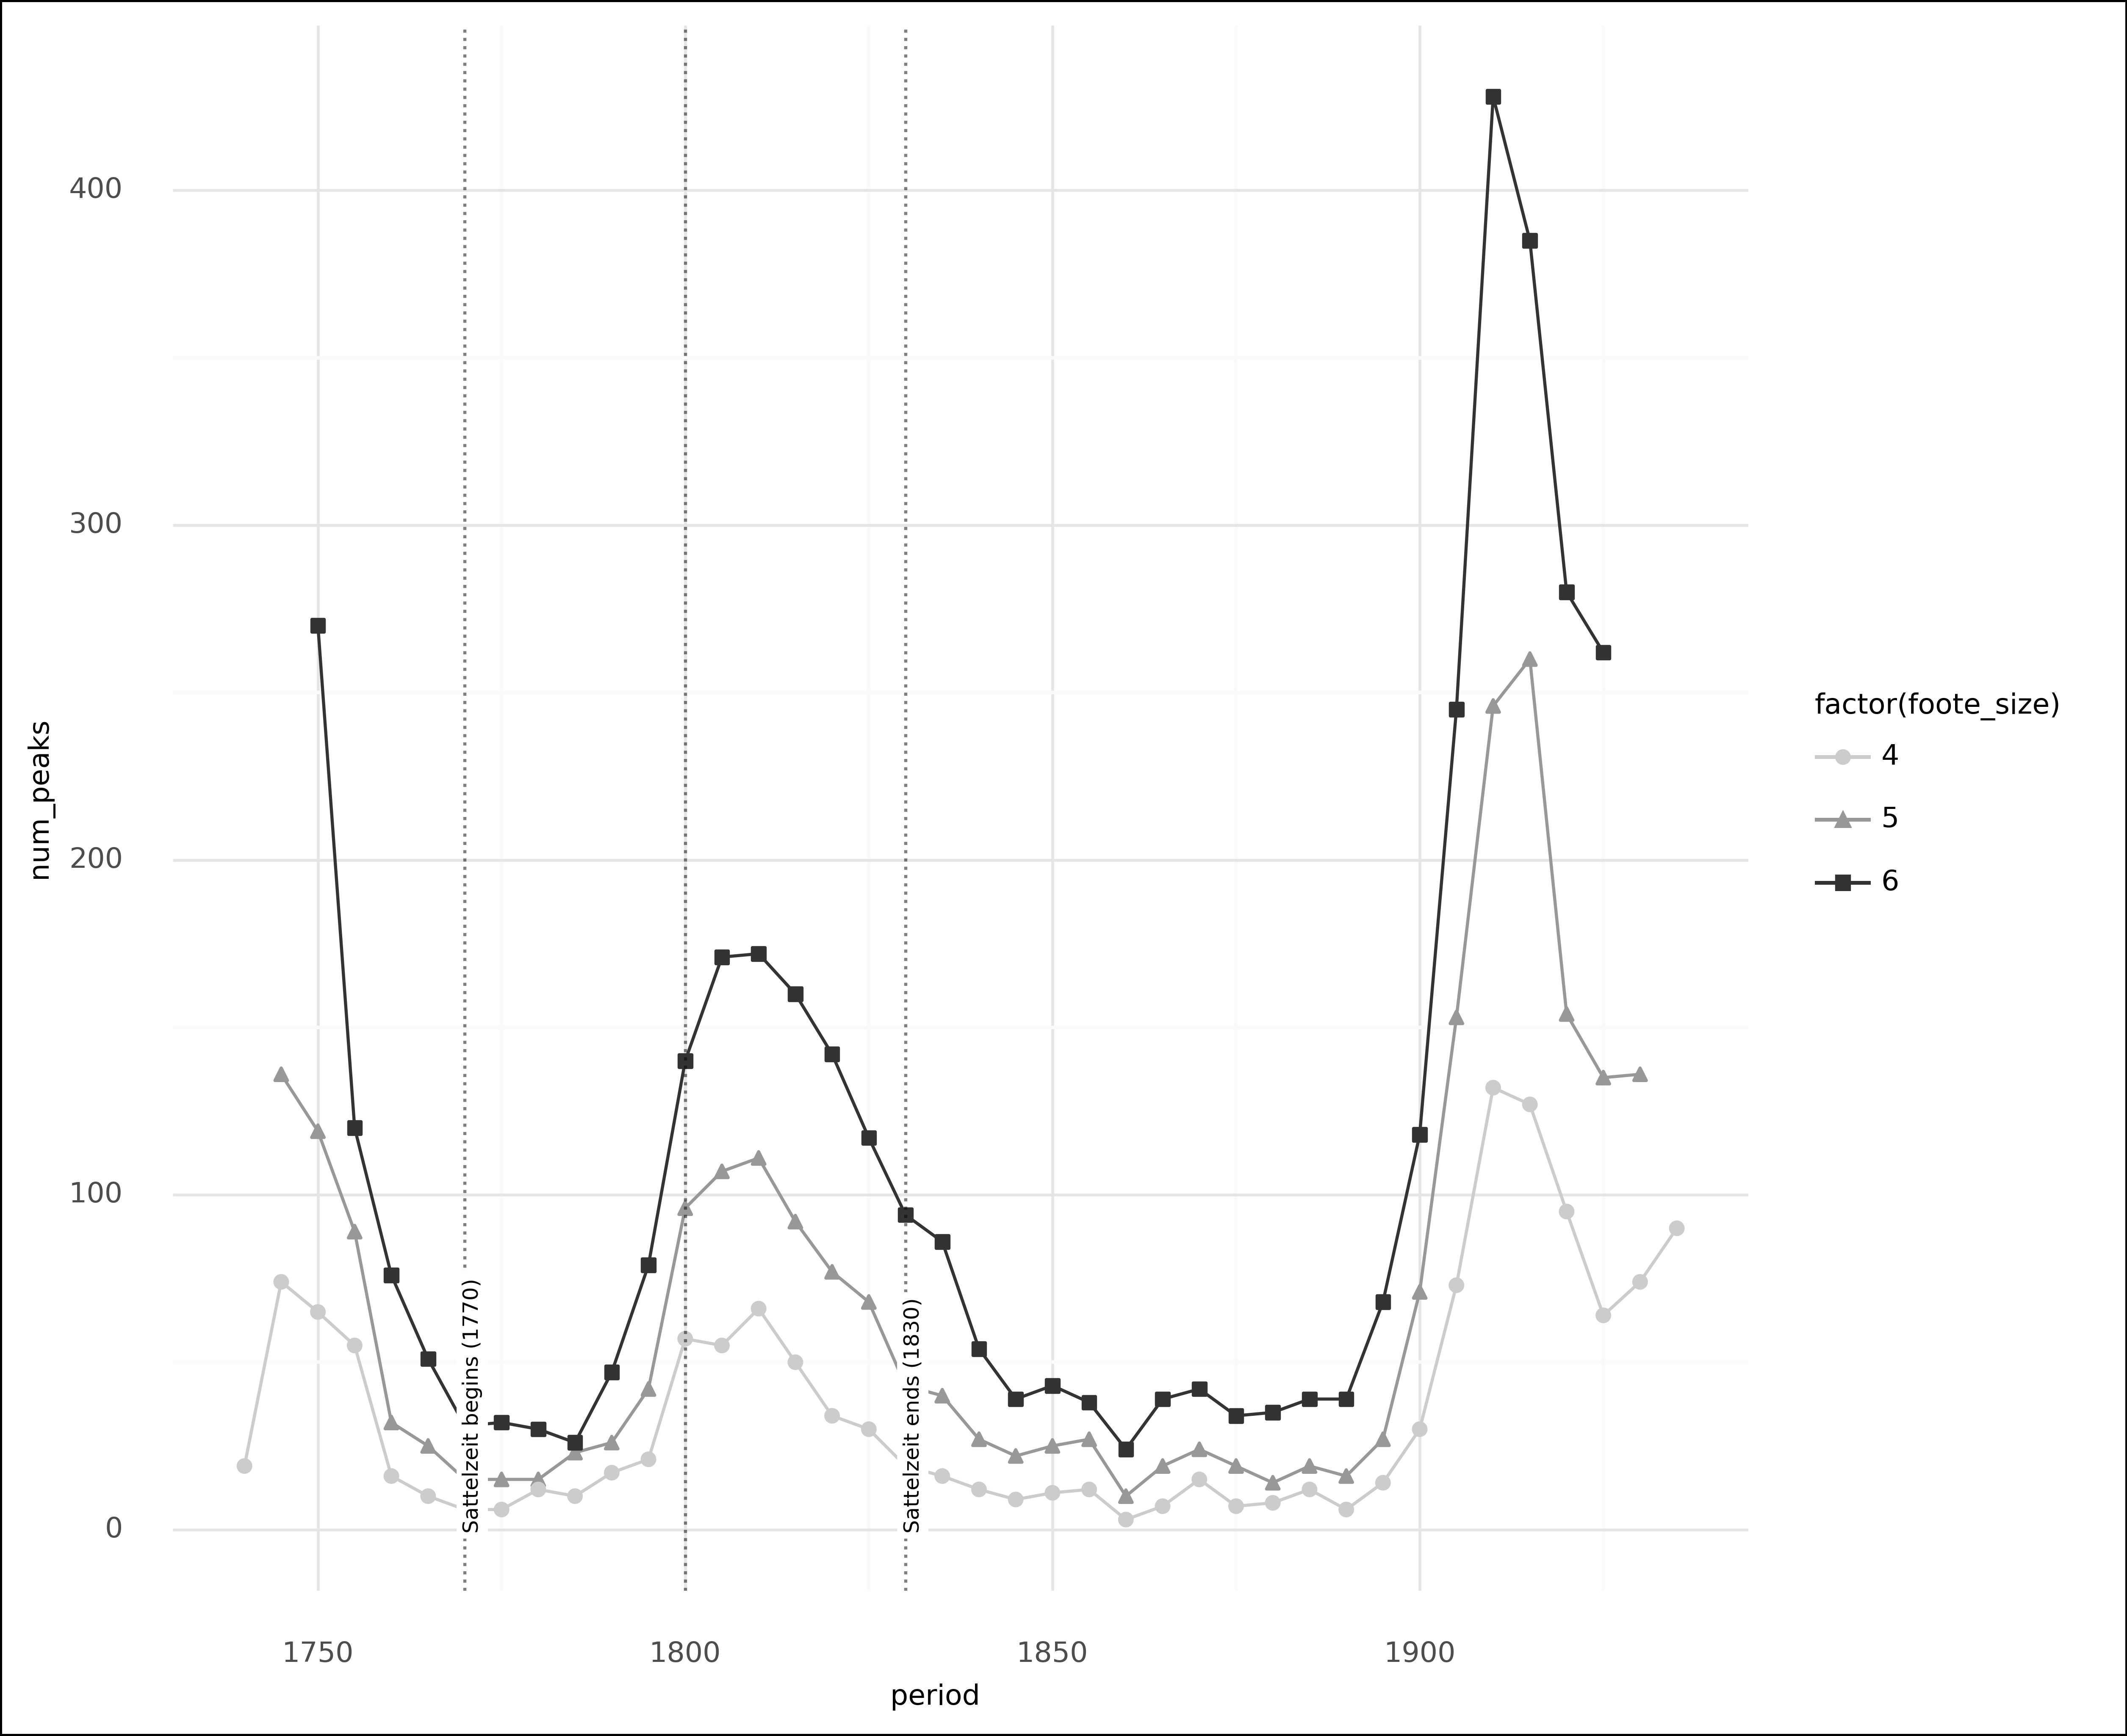

<ggplot: (8771728062493)>

In [70]:
plot_novelty_by_foote_size(rolling=1, p_peak=.01, min_peaks=1)#, words={'culture'})

# words used: 1


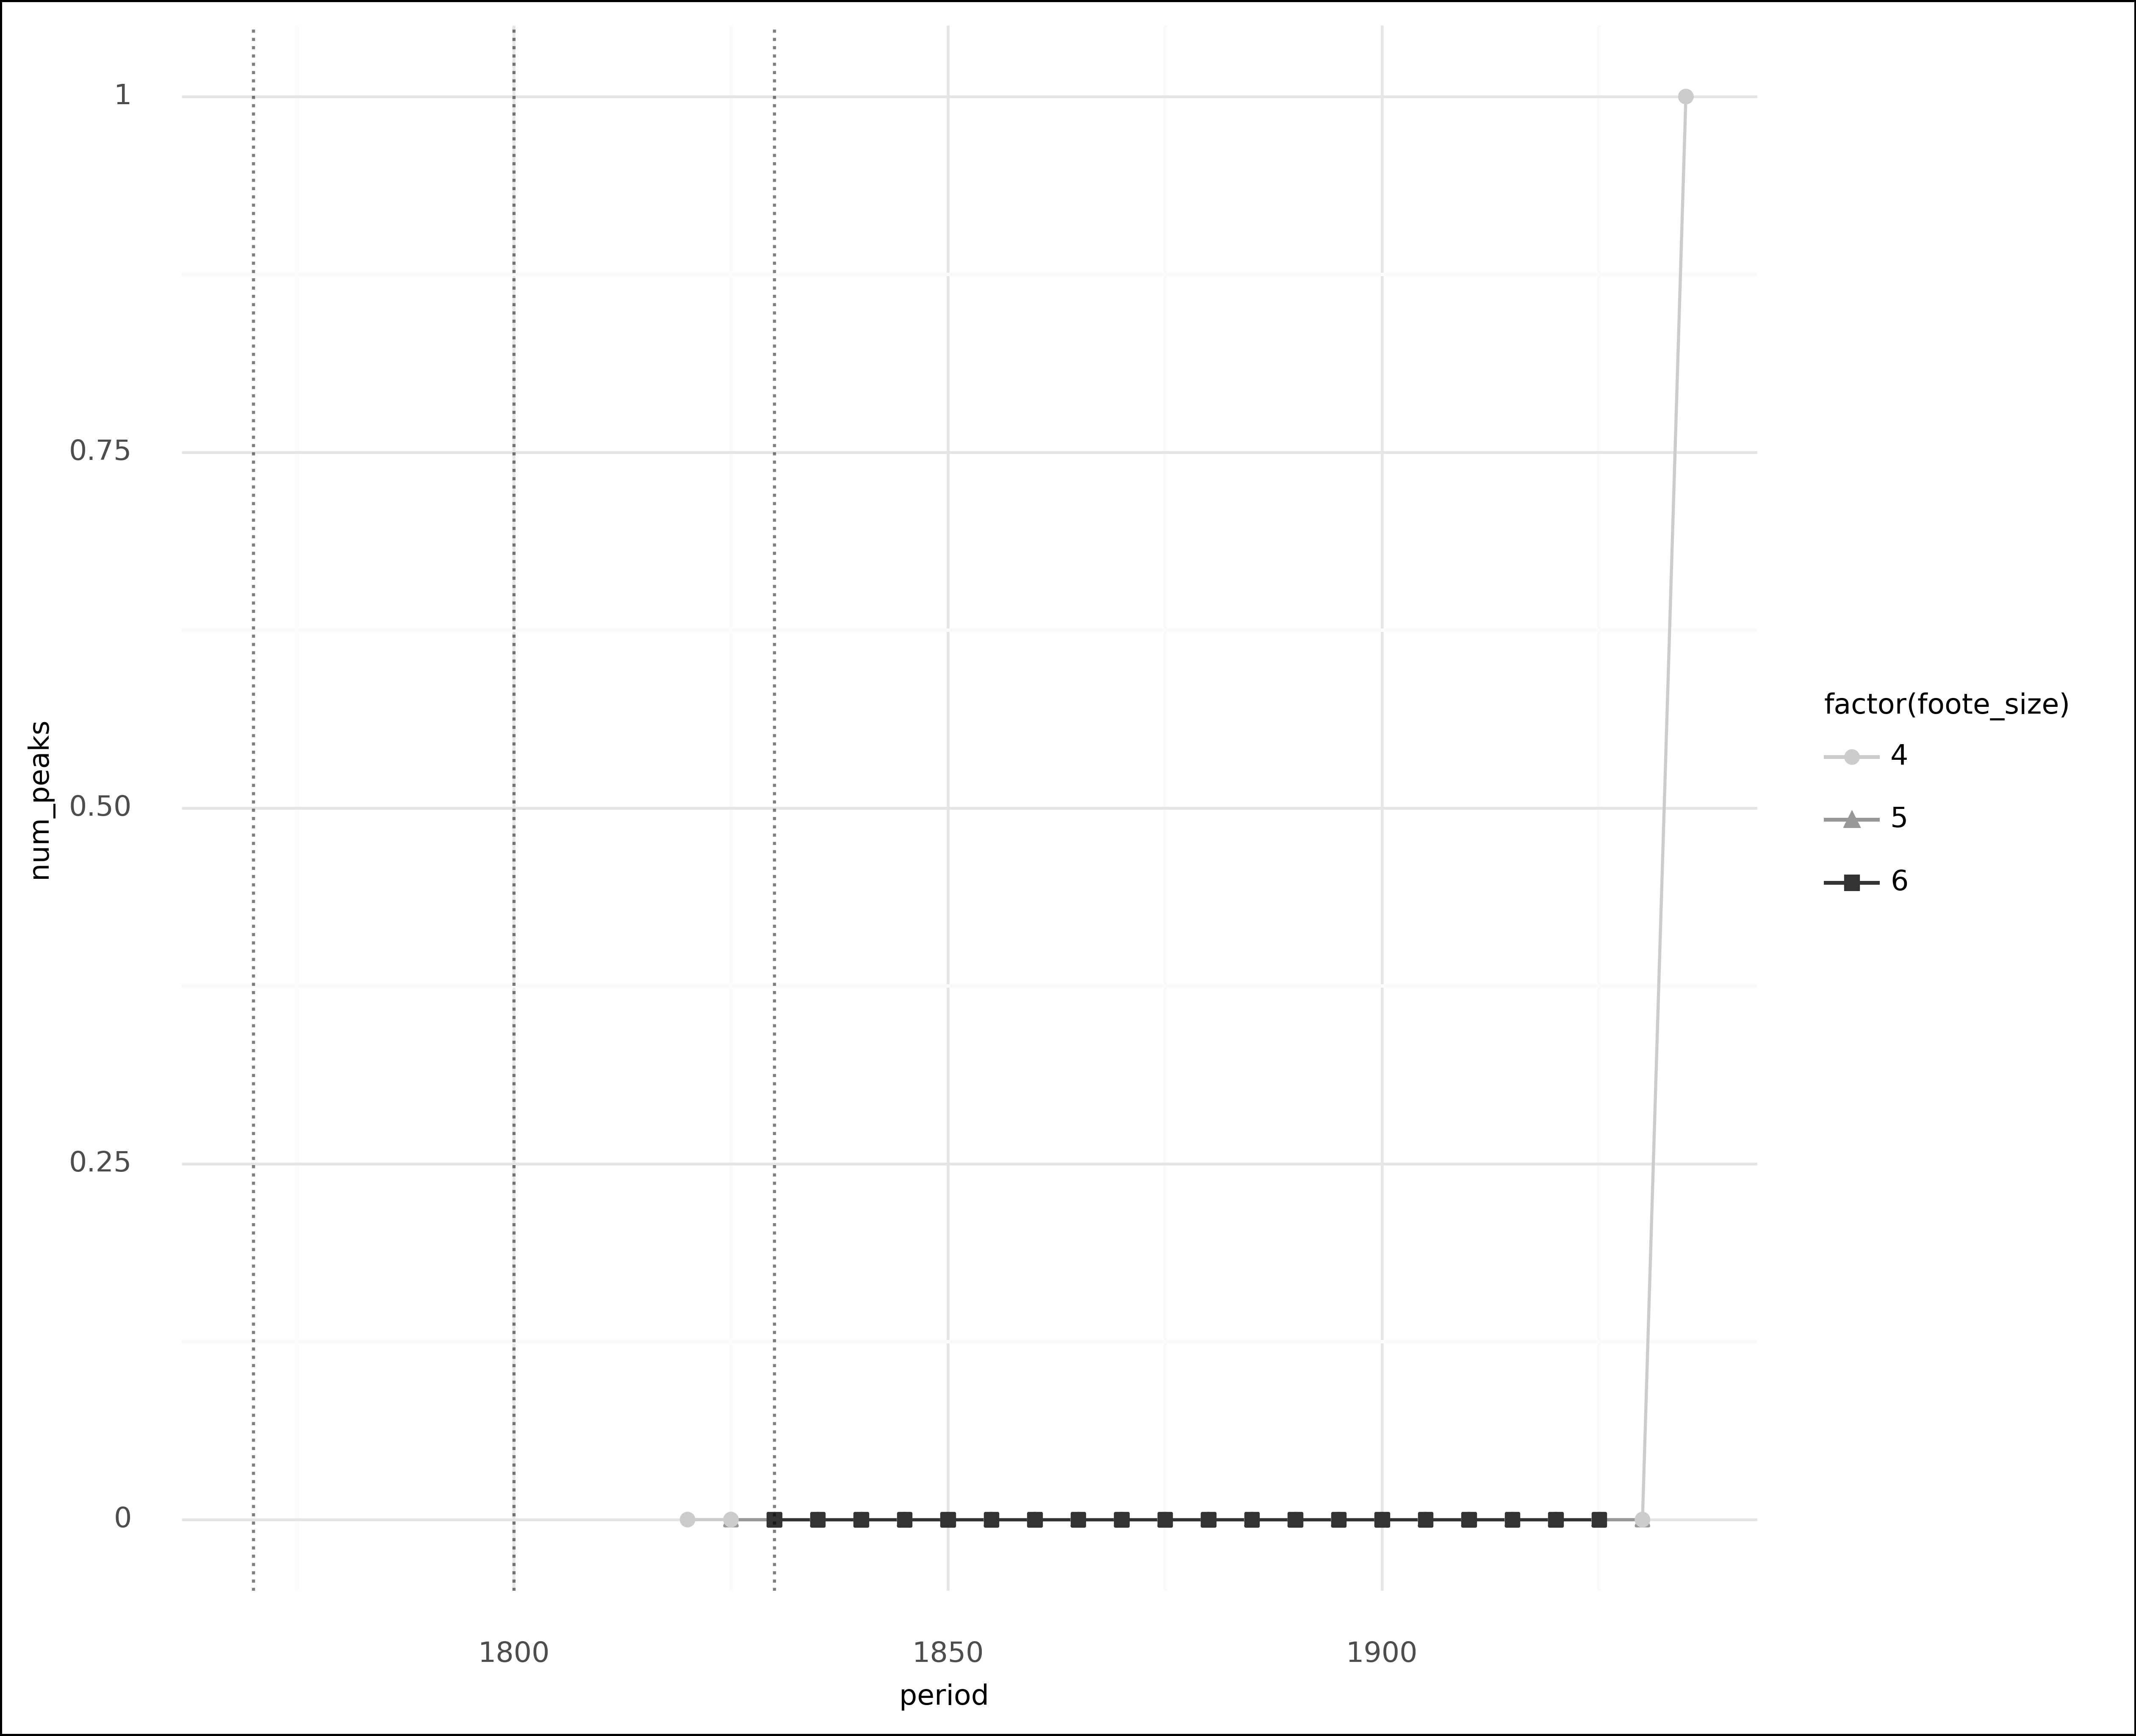

<ggplot: (8771728062469)>

In [71]:
plot_novelty_by_foote_size(rolling=1, words={'potato'})

In [72]:
dfchangepoints=get_signif_novelty_scores(p_peak=.05, min_peaks=1).drop_duplicates('word',keep='first').sort_values('period')
dfchangepoints

,word,period,foote_novelty,p_peak,p_trough,foote_novelty_z,word_num_peaks
19175,brick,1750,20.011508,0.03,1.0,1.859859,1
51343,drawing,1750,18.482221,0.00,1.0,1.591477,1
2874,advertisement,1750,20.569041,0.00,1.0,1.957704,1
28087,circle,1750,23.593007,0.00,1.0,2.488395,4
120829,poet,1750,15.522215,0.00,1.0,1.072010,2
...,...,...,...,...,...,...,...
100922,mercy,1925,13.165865,0.04,1.0,0.658481,1
50087,doc,1925,33.729291,0.00,1.0,4.267265,2
33006,composition,1925,26.186400,0.01,1.0,2.943523,1
40481,crying,1925,13.151669,0.01,1.0,0.655990,1


In [73]:
odfstr=pd.DataFrame([
    {'period':period, 'words':', '.join(grp.sort_values('foote_novelty_z',ascending=False).word)}
    for period,grp in sorted(dfchangepoints.groupby('period'))
])
printm(odfstr.to_markdown())

|    |   period | words                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
|---:|---------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 |     1750 | admiration, breath, veil, price, arch, area, skin, angel, gravel, lark, toy, bottle, yard, temple, root, solution, packet, bladder, publication, repose, lime, breeze, dew, corpse, bible, dung, tumult, gale, poem, pine, tavern, prop, lamp, copper, sale, chat, edge, wind, size, juice, narrative, lake, belly, void, duck, loan, depth, commander, surface, cloud, sentiment, ibis, epistle, height, malignity, snow, perusal, pamphlet, miracle, frown, volume, base, scale, annuity, dove, patient, cheese, tear, circle, system, painter, square, parade, turnpike, experiment, unity, ridge, rose, cedar, preface, solitude, darkness, serpent, amazement, cone, top, intercourse, bottom, simplicity, gate, shop, mortar, weeping, devotion, disorder, substance, animal, weakness, vivacity, plate, food, chronicle, level, coinage, credulity, advertisement, commencement, valley, roper, hunger, rock, opening, dream, correspondent, fever, brick, pillar, fondness, gratification, quotation, wood, deer, writer, breadth, girl, improvement, eon, continent, limb, process, section, firmness, introduction, july, imagination, collection, translator, humanity, feeling, sex, editor, combination, criticism, drawing, emperor, recommendation, smell, tail, plan, painting, journal, poetry, summer, jealousy, vehemence, space, remark, affection, taste, scope, review, amusement, print, friday, aunt, river, tongue, path, exhibit, result, picture, incident, benefit, reward, invitation, style, tree, story, poet, thursday, february, october, historian, surprise, window, moment, voyage, controversy, january, beard, apology, abundance, valour, june, winter, step, sunday, page, extent, verse, interval, series, husband, figure, widow, august, november, water, difference, pocket, friendship, enjoyment, rate, turning, princess, age, class, conclusion, woman, departure, discovery, reflection, family, trouble, calling, prospect, language, saying, afternoon, ground, home, hill, compliment, door, witness, subject, reader, dinner, mistake, night, office, century, reading, fact, period, telling, letter, form, mother, work, friend, history, effect, book, journey, taking, source, instance, progress, writing, fortune, child, end, day, point, place, confidence, degree, desire, year, beginning, coming, attention, hand, deal, reason, country, mind, art, word, experience, business, fear, house, time, life, part, occasion, world                                                                                                                                                                                                                                                                                                                                                                           |
|  1 |     1755 | sake, medicine, stomach, scurvy, efficacy, cure, corner, suit, exchange, appetite, poultry, gift, dose, infant, pot, acre, contentment, side, discussion, novel, production, span, ferment, edition, palate, beach, confinement, agony, patriotism, farewell, guile, melancholy, rice, epitaph, symptom, echo, conviction, artist, brain, dagger, essay, retirement, ingenuity, information, fortitude, effort, anxiety, sign, tuesday, topic, paragraph, table, companion, detail, familiarity, week, boy, december, father, impression                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
|  2 |     1760 | fiend, citizen, lava, spreading, club, adventure, consolation, imbecility, store, spectator, thistle, auditor, dole, challenge, career, pudding, analysis, duchess, standing, room, abode, saturday, disgust, connexion, spot, treasure, date, illness, lover, reply, way, search, opportunity                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|  3 |     1765 | mode, mead, vest, leopard, succession, bud, portrait, accomplice, march, renewal, monopoly, game, storm, theory, tour, counsel, equality, chair, village, debate, prejudice, article, neighbourhood, interview, note, traveller, soldier, success, conversation, attempt, importance, advantage                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
|  4 |     1770 | judgement, healing, independence, motion, carriage, magnitude, genus, moon, tension, liberality, codex, pennant, restitution, elector, habit, minute, authenticity, canoe, amendment, queen, closing, reproof, anarchy, desolation, jury, decision, object, matter                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|  5 |     1775 | goal, zinc, correspondence, holiness, blood, horizon, hearth, impudence, era, commendation, cadence, chill, barrack, flesh, crisis, desertion, proposition, complaint, advice, permission, prisoner, line, promise                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|  6 |     1780 | reform, fox, moving, charcoal, chancellor, flower, bail, insertion, exchequer, code, shark, delineation, abolition, convulsion, termination, transportation, pang, expediency, accommodation, fervour, uproar, direction, forgery, estimate, prison, task                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
|  7 |     1785 | gas, slave, adoption, trait, vicinity, jelly, machinery, test, feature, cough, angle, enthusiasm, dairy, deluge, sweat, heat, tool, mister, dragoon, prodigal, president, exhortation, cessation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
|  8 |     1790 | case, intellect, decree, district, soul, resistance, hostility, sheen, dwelling, highway, sty, diadem, allure, celebrity, lobby, ratio, restoration, warfare, printing, robbery, contrast, civilization, organization, conspiracy, redeemer, strait, thermometer, successor, scenery, cheerfulness, sequel, audacity, tribe, province, hesitation, pause, determination, suspicion                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|  9 |     1795 | sum, rise, soil, hare, stock, oats, forte, landscape, rye, bile, originality, pork, insurrection, embassy, dock, printer, ending, breeding, peal, writ, stamp, outline, shipwreck, banner, mania, recollection, proclamation, solicitude, attendant, income, population, operation, risk, retreat, giver, destruction, regiment, summary, disuse, completion, term, waste, exception, hatred                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| 10 |     1800 | expense, sound, sect, sitting, sort, demand, seat, list, mist, correctness, lace, son, sub, grain, sight, dress, lust, stain, railing, struggle, institute, sink, suicide, frill, consistency, crop, hook, nod, bonnet, mailer, atonement, resurrection, lecture, gig, substitute, filly, bushel, flash, workmanship, creed, shoemaker, sailing, fink, rectory, pastry, pear, seminary, destiny, consul, market, stoppage, construction, actor, mansion, cadet, cord, brightness, climate, characteristic, shipping, sweep, chairman, contradiction, rent, group, palace, sun, kinsman, spire, refreshment, affront, cornice, quantity, scarcity, recess, museum, morrow, reviewer, aspect, misconduct, amount, discrimination, capital, listening, dollar, fashion, obstacle, weather, pestilence, report, value, establishment, rest, disapprobation, disposal, nephew, island, question, supply, money, kind, evidence, fall, master, city                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 11 |     1805 | hip, filter, mud, rill, conduit, hall, flood, examiner, stil, chase, stall, whore, newspaper, coon, canning, isle, fat, sill, manufacturing, liege, stimulus, memoir, lass, richness, ass, vicar, sleeve, shoulder, stem, sculpture, reduction, magistrate, dill, institution, muslin, profusion, ostrich, colour, treatise, gauze, seller, catechism, robe, mockery, heft, mission, sympathy, priesthood, ascendancy, sack, glen, gallery, crag, wick, coast, fort, sou, mineralogy, subsistence, passenger, feud, abbe, ash, stat, castle, cost, clemency, fitter, stretch, suppression, selling, baud, ox, inquisition, communication, sofa, diminution, repast, guide, vase, inspection, domination, saving, tiger, descendant, niece, correction, sanction, pilgrimage, pail, peninsula, glimpse, predecessor, idol, confessor, expulsion, liar, prefect, identity, quarter, embarrassment, occurrence, outset, stanza, chivalry, hardship, colleague, employment, expedition, leader, foreigner, clock, plot, access, generation, wife                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| 12 |     1810 | foil, sin, belt, slate, flock, fad, fame, feat, ruffian, muff, welt, mall, missionary, elf, depression, bark, fir, shaft, urge, exposure, rector, spell, suggestion, composer, mutt, disease, plea, halo, abbey, steam, inquest, inflammation, erection, slumber, terrace, fable, empress, sinner, musician, fostering, truck, currency, heresy, jurisdiction, commissioner, peak, shadow, zephyr, renown, document, irritability, stuff, raft, ilk, usefulness, stocking, extinction, sabre, mule, cow, flue, jug, legend, peasant, chaplain, lightness, greeting, sting, subjection, apathy, medallion, injunction, republic, sadness, arsenic, mill, concession, fortification, insanity, grandson, bast, curl, crack, aristocracy, expenditure, moor, chili, exclamation, grandeur, skeleton, portraiture, pew, treasurer, exclusion, statement, ship, kite, awe, consummation, discontent, mane, monument, nuisance, phraseology, dispensation, retention, aide, heiress, speculation, parish, puss, brace, destination, governess, dynasty, panic, interpreter, severity, inconsistency, proportion, trifle, rebuke, memory, coincidence, clergyman, punishment, sea, protest, garden, ride, interest, arrival, number                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| 13 |     1815 | fee, fun, loft, labourer, sway, fleet, transport, distress, pall, tilth, opera, comedy, patriot, pantomime, mercury, vestry, dome, ballet, rebus, portal, responsibility, gazette, threshold, darling, execution, bouquet, glow, medal, saddle, presidency, reek, farce, privateer, tome, stile, vicarage, basin, gun, archdeacon, theatre, niche, hail, sis, cock, mining, instinct, fence, skull, myrtle, control, drama, stigma, stool, manager, cannon, frolic, tinder, dialogue, toot, elegy, overseer, muse, nymph, cathedral, deck, compromise, nursery, blackness, sos, performer, relic, emblem, emigration, mate, geometry, scrutiny, schism, stair, mien, goddess, fool, baptism, ice, bolt, auction, catastrophe, pulse, martyrdom, exterior, pinnacle, nap, knave, sportsman, shouting, assumption, desk, arbour, whistling, weapon, idiot, popularity, exaggeration, committee, genius, brute, litigation, discipline, persecution, penalty, cross, commission, vote, absence, affair, piece, break                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| 14 |     1820 | performance, strand, excitement, grove, chorus, cell, vale, lane, slavery, maid, entertainment, park, intensity, vagrant, champagne, rift, song, livery, temperament, moss, sunset, flank, guest, moat, foam, blast, cheek, cat, lip, sky, meal, meadow, supremacy, ballad, post, singer, font, pretension, clover, applause, admittance, site, neutrality, cloak, bush, engagement, virgin, aperture, exhibition, banquet, slice, roar, speck, archbishop, tent, mask, sage, contributor, receiver, moonlight, heretic, core, seclusion, flag, carelessness, pheasant, truce, harlequin, snare, fitness, forest, data, tributary, scribe, enemy, dissent, routine, holiday, tomb, recreation, anniversary, chop, doctor, informant, contact, matron, surgeon, irregularity, bitterness, acknowledgment, intercession, surname, inventory, suitor, sailor, joke, malice, infidel, arm, finger, attack, army, injustice, evening, war                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| 15 |     1825 | regent, street, grass, culture, daylight, theme, charm, toil, butcher, intelligence, staple, music, lyre, vegetation, repository, query, manifestation, rehearsal, rail, brow, convoy, recitative, miscellany, annoyance, meantime, legislation, collision, contra, jet, rod, scrap, season, dick, bell, mound, thorn, basement, bribery, glade, troop, goblet, rabbi, vein, selfishness, dispatch, beech, ascendant, damage, sanctuary, hitter, bravo, message, sand, smoke, quill, distrust, merriment, exile, englishman, observance, wednesday, rain, beer, stranger, thinking, prince                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| 16 |     1830 | cloth, linen, sport, sowing, merchant, maker, temperance, shopkeeper, straw, tact, tailor, seed, wave, row, insurance, hunter, barley, canto, inn, hay, flax, bookseller, walker, sooth, almanac, turnip, sheep, penny, bier, innkeeper, enigma, pasture, manufacture, physic, woe, beef, specie, longing, pack, studio, planting, lard, glance, craving, gem, host, recognition, bit, masque, apprenticeship, gravity, scent, rush, attraction, apothecary, tanner, dealing, strife, sculptor, enlargement, dismay, suffrage, rivalry, impetus, mote, luck, majesty, mile, secretary, pace, couple                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| 17 |     1835 | element, bonus, op, orchestra, league, trio, organ, bass, conductor, concert, symphony, orb, piano, harp, solo, builder, oratorio, assurance, boon, violin, cantata, dart, broker, masonry, finale, ravine, locality, dealer, premium, quadrille, baker, carpenter, training, border, farmer, development, rib, hemp, position, guitar, compendium, mess, mason, bank, timber, intervention, lore, vitality, vocation, smile, trump, crape, mutton, craft, monday, lam, tenacity, tableau, expanse, promenade, endurance, banker, association, sojourn, convocation, ringing, symbol, canal, admission, judaism, bane, revolt, narrowness, vindication, endowment, aim, stagnation, limit, starvation, bench, rule, example                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| 18 |     1840 | tenor, band, telegraph, shrine, pottery, papacy, cab, contribution, azure, sales, glacier, postage, luggage, varnish, device, coil, plastic, lack, torch, notation, rebel, epilogue, parapet, punt, paint, sod, pate, bum, ping, foe, formula, dash, wail, cent, pauper                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| 19 |     1845 | train, calf, gilt, strip, balm, melting, envelope, calico, beam, scandal, alley, bedding, mix, trail, receipt, zone, tint, incarnation, relationship, completeness, ointment, gallon, inspiration, pic, array, winch, pencil, wrench, railway, catholicism, verdict, fascination, abhorrence, fraction, relief                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 20 |     1850 | crystal, station, corn, prelude, boll, significance, pet, pallor, glee, dating, truss, application, cheque, consumption, sloop, dye, rite, prospectus, debility, jar, conception, inauguration, adhesion, habitation, acceptance, toad, wrestling, ugliness, serenity, blunder                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 21 |     1855 | choir, sugar, disc, volunteer, balcony, reproduction, tune, oil, conflict, lemon, companionship, walnut, devil, masterpiece, remedy, caution, dogma, sublimity, sequence, deli, ordinance, popery, parable, dungeon, ounce, prominence, commodity, lawyer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 22 |     1860 | domain, crown, curate, panorama, meteor, sewing, sphinx, paving, folk, wage, entirety, annex, rant, spleen, adjustment, lunch, halt, regeneration, generality                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 23 |     1865 | recital, sonata, frigate, unison, chant, overture, flute, morn, caprice, thud, unit, greed, slit, chord, advertising, chain, bureau, harpsichord, groove, jew, musket, dolly, workman, luncheon, emulation, etching, debtor, famine, colonel, extract                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| 24 |     1870 | gaiety, rendering, communion, evolution, factor, cotton, anthem, royalty, minuet, restorer, fantasia, spark, fugue, criterion, andante, role, adagio, scherzo, ensign, headache, butt, surveyor, viol, octave, compass, licensing, baking, draft, celebration, ado, islam, vantage, commune, parcel, vigilance, reminiscence, iniquity, ancestor                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| 25 |     1875 | staff, suite, agency, string, pitch, counterpoint, column, lute, certificate, junction, bibliography, dam, foal, membership, affliction, serf, infirmary, setting, idolatry, pioneer, wretchedness, decade, road, dignity, month, opinion                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 26 |     1880 | federation, contention, frame, redemption, viaduct, sig, manual, rhapsody, firm, cricket, matriculation, onion, pipe, expert, schedule, evangelist, alcohol, diligence, engraver, trumpet, iron, ingratitude, chatter, tiling, issue, conceit, confirmation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| 27 |     1885 | syllabus, avenue, team, cult, personality, exam, prism, electorate, guild, realism, anthology, initiative, socialism, cheapness, sideboard, nucleus, prudence, formation, import, dentist, apocalypse, competitor, deity, ward, oxide, astronomer, indictment, stead, incline, journalist, contest, supposition, creditor, seriousness, indolence, mortification, genuineness                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 28 |     1890 | funk, potash, duct, approval, diploma, quiver, craftsman, buckle, rider, yoke, tragedy, ray, trainer, liquor, gunpowder, infidelity, tram, china, mare, fossil, hydrogen, oven, calmness, peculiarity, secession, stress, dreamer, pendulum, repentance, council, maxim, acuteness, compound, promoter, sincerity, oratory, branch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| 29 |     1895 | tsar, depreciation, chap, constable, attachment, tempest, cycle, polo, expansion, atmosphere, dent, burglary, golf, glamour, tab, detective, benediction, mourning, guardian, magnetism, membrane, fiction, absorption, impostor, spa, penitence, rape, projection, reverie, restraint, informing, peerage, creator, fusion, awakening, mainland, mythology, preference, constancy, industry, regularity, submission, propriety, veneration, reliance, impartiality, fore, argument, generosity, situation, concern                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| 30 |     1900 | sphere, reception, scotch, turf, housing, freehold, hotel, purity, kaiser, outlook, detachment, electricity, fountain, feeding, delivery, marsh, grocer, texture, chemist, residence, razor, brand, saviour, simile, packing, proprietor, influenza, sheet, assessment, mysticism, fatigue, lock, superintendent, propagation, coronet, salvation, circuit, combustion, photograph, breathing, cigarette, animation, bean, cruiser, poo, covenant, sabbath, persuasion, excellence, filling, file, hierarchy, labour, grenadier, haven, resort, cottage, corporal, trunk, nobility, hiring, millionaire, displeasure, duke, captivity, forethought, pretence, guilt, news, king, town                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| 31 |     1905 | proof, treatment, comfort, hem, car, cup, vehicle, safety, complexion, scalp, derby, aerial, asset, trial, ger, handicap, milk, toll, margin, unrest, trophy, bystander, ex, irritation, oxygen, ally, representation, range, suspension, mixture, bus, aquarium, carbon, righteousness, installation, exhaustion, ham, yen, intimacy, champion, tote, sentimentality, squire, ore, sulphur, forgiveness, yew, steel, pastor, roughness, fishing, boating, planning, despatch, nourishment, lotion, tike, mew, steeplechase, flavour, corporation, shawl, latitude, reservoir, cooking, propaganda, sample, menace, tribune, shield, aroma, vacuum, pier, requirement, idiom, ace, flexibility, softness, hose, injury, auto, mite, yearning, interpretation, reporter, cavern, gut, bamboo, runner, plunder, threat, pageant, parchment, immortality, chess, conveyance, trading, rink, casement, futility, gal, arena, crocodile, dismissal, reproach, ether, playhouse, copyright, running, bargain, adviser, coarseness, customer, circumstance, indulgence, release, democracy, hunting, bewilderment, prophecy, alphabet, multiplication, discomfort, deliverance, explorer, wayside, peer, rumour, opponent, wound, health, warning, curiosity, hint, choice, character, spirit, influence                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| 32 |     1910 | fur, bust, request, coat, cam, acid, hair, waist, tablet, refinement, cream, shade, germ, manufacturer, sunbeam, patent, economy, perfume, fulness, selection, cylinder, engine, metal, tube, lustre, fragrance, decay, sultan, salon, catalogue, ivy, salt, freshness, wheel, contour, fuel, platinum, brochure, bloom, salad, con, overcoat, bee, warmth, dish, marquess, pattern, machine, model, vogue, butter, tweed, coach, kit, dad, vapour, millinery, ribbon, ivory, triangle, shoe, pinch, collar, tan, pepper, corsage, soap, job, beet, lawn, ban, liner, bout, thickness, brush, valve, hypothesis, satin, shirt, delicacy, wad, fleece, temperature, cancer, embroidery, gable, tournament, durability, fiat, ling, smoothness, greyhound, mahogany, structure, measurement, farmhouse, hammer, jam, mirror, heel, ad, specification, gent, speciality, waistcoat, sash, acidity, brim, chancel, arcade, egg, ventilating, tract, lyceum, feather, equipment, chamber, whisky, pavilion, tunic, diameter, shape, speed, neck, perfection, curry, championship, corset, rebuilding, bowl, velvet, cleanliness, lighting, dot, sauce, submarine, emerald, satisfaction, vim, oak, dilemma, neuralgia, driver, hurdle, throat, pearl, brocade, sketch, apparatus, mantle, eld, touring, camel, earl, efficiency, lighthouse, sapphire, mosque, warehouse, globe, grease, char, semi, thread, rheumatism, nose, bath, paste, orbit, chine, brushing, cart, shopping, grit, moisture, whip, pavement, papa, cap, crypt, visitation, strap, package, welter, ocean, soda, clutch, brass, whit, arabic, obligation, skating, frieze, viscount, prescription, shower, syrup, slab, maple, flora, maw, wire, curve, lotus, boom, accessory, humbug, beak, physician, bom, den, brook, pair, plantation, peace, insect, goodness, throng, toothache, apostle, novelty, sheriff, ermine, fragment, leaf, beverage, brine, fidelity, factory, rigging, piazza, forehead, courtesy, stalk, service, obedience, pulpit, lieutenant, apron, coolness, wearer, genesis, dean, vanity, eloquence, jerk, victory, mouth, elasticity, wreck, verb, grant, antidote, sharpness, protector, charter, edict, manipulation, penetration, outlet, dissolution, charity, agreement, neigh, pope, antiquity, providence, astonishment, sword, limitation, dexterity, settlement, moustache, hanging, inferiority, emergency, chaff, lifetime, faction, restriction, assertion, prophet, vigour, tier, solemnity, impatience, compiler, furniture, tradition, debut, vengeance, species, accusation, repair, mankind, gambling, weight, priest, body, lady, faith, compilation, anecdote, reputation, creation, wisdom, intimation, ease, confusion, brother, approach, event, violence, copy, danger, appearance, virtue, credit, reign, field, self, throne, kingdom, head, pleasure |
| 33 |     1915 | nave, revue, garment, film, tin, navy, appointment, toe, wool, imitation, bat, gown, panel, frock, powder, tar, silk, skirt, flint, kennel, botany, smartness, cologne, width, nigger, aisle, fabric, fern, puff, protection, leather, seal, tenant, tower, mat, flannel, ledge, par, knitting, cleansing, lather, porch, borough, crepe, bishop, toilet, maternity, rugby, clothing, bot, heather, axis, cemetery, swan, abbot, preparation, carving, mem, ritual, tank, mum, excursion, kid, churchyard, pain, earnestness, treaty, grate, stone, dog, bodice, lever, sandwich, torrent, vat, manor, fraud, pe, mineral, vocabulary, twill, washing, elegance, drapery, doorway, research, jacket, axe, recording, pilot, edifice, cookery, perspiration, baby, willow, mummy, sim, tobacco, odyssey, eagle, plank, canvas, bidding, tooth, dancing, quality, plaster, ape, litter, cairn, design, sine, fastening, nook, brake, hospital, decoration, infection, ref, bronze, pique, hum, costume, perspective, lightning, pitcher, glass, priory, publicity, spring, gauntlet, pub, armistice, tenderness, wall, trot, hat, department, piety, anatomy, shriek, dictator, ration, marchioness, ordination, meat, chin, earthenware, traffic, tern, furnishing, wine, spice, fineness, rejection, wax, homer, leadership, shore, reconstruction, cricketer, remorse, pin, centre, oat, realm, whirlwind, railroad, dirt, chariot, hen, purse, statue, ceiling, bow, religion, horseman, turret, spy, worship, policy, rudder, government, alarm, boat, inventor, apex, transformation, archaeology, cot, knife, spelling, ditch, hag, apartment, haste, grace, slope, variety, likeness, dryness, burial, odour, cardinal, daughter, candidate, commentary, strategy, fish, altar, aid, elder, masse, grave, metropolis, posture, fury, campaign, motto, siege, insult, moderation, civilisation, vividness, building, material, lordship, indignation, disappointment, court, distinction, plague, revenge, preservation, uncle, midst, mayor, length, abuse, defeat, heir, rank, freedom, servant, officer, nation, temper, birth, happiness, lord, support, charge, name, gentleman, care, order                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| 34 |     1920 | wit, tee, eve, arithmetic, producer, sunshine, bid, cork, player, architect, screen, background, race, grammar, pal, tutor, lilt, gear, saloon, roan, cape, revelation, grade, atlas, pact, rouge, putt, cur, framework, pedigree, cardigan, pension, tot, steering, asylum, stitch, tic, ide, colouring, librarian, gin, tonic, hole, causeway, engineer, rem, engineering, terrier, handbook, ski, contract, product, floor, squirrel, reformer, rover, mam, vault, heating, battery, magnesia, ball, display, sot, gospel, pore, lair, conversion, beauty, lavender, rat, joy, scarf, brandy, colt, booking, gum, pathway, connoisseur, ministry, seating, swimming, chimney, itinerary, horse, streak, university, load, utility, hive, shock, yachting, directory, dame, canon, operetta, enamel, aristocrat, inscription, dread, tine, shot, magazine, nut, girdle, hut, chapel, wrath, kin, puppy, supporter, vet, ornament, appendix, pyramid, symbolism, legion, hound, proficiency, humour, chart, superstition, fauna, divinity, effigy, exploration, rendezvous, enclosure, bey, villain, detection, revision, allusion, map, crash, recovery, gallop, conference, apparel, glory, countenance, welfare, reverence, condition, funeral, stove, passion, reformation, absurdity, sermon, questioning, measure, property, testament, precaution, deference, conscience, author, behaviour, distance, zeal, audience, meeting, philosopher, sacrifice, cause, assistance, church, manner, favour, man                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 35 |     1925 | tie, star, broadcast, foundation, fullness, ensemble, harmony, lid, harvest, ant, geography, winner, mathematics, lamb, chemistry, omnibus, flight, frontispiece, inspector, carol, ire, vita, ale, tit, ballroom, score, doc, loveliness, physics, goo, pool, breast, scholarship, marble, flying, bacon, cocoa, bay, bar, crook, tilt, circulation, prayer, ion, precision, teacher, bobby, autograph, vision, mu, tuition, nit, messiah, lecturer, robin, sire, murmur, coward, removal, holder, quest, coaching, hymn, philosophy, liability, examination, kitchen, suspense, rally, director, version, porcelain, dictionary, gloom, observatory, cellar, registration, ton, stud, salary, scoring, jewellery, cradle, shepherd, gi, composition, resignation, pa, classification, stillness, mil, jumping, carrier, heaven, crime, rig, hedge, gateway, vessel, pony, continuation, hoe, gliding, cuckoo, graduate, thanksgiving, mechanism, ting, tile, glare, tow, dance, loo, blessing, resident, snipe, shorthand, congregation, clause, glimmer, bill, county, pan, engraving, anguish, wing, apple, thrill, centenary, tone, windmill, god, sorrow, bounty, accumulation, curb, mountain, instruction, surf, demonstration, pupil, negro, teaching, cad, pathos, desert, christianity, stag, maintenance, casting, brood, clearness, integrity, passage, force, hell, handkerchief, wilderness, interlude, petition, magnet, fare, party, thunder, resolution, jock, signature, splendour, reporting, crew, ghost, staircase, cave, mirth, practice, facility, boundary, method, instrument, paradise, auntie, horror, grief, myth, accident, roof, advent, translation, bread, dawn, lung, hack, prose, convenience, balance, repetition, murder, student, accent, science, option, beggar, origin, consent, security, lad, crush, tide, elephant, prey, dining, repertoire, drinking, proposal, thirst, keel, academy, accuracy, terror, avail, study, murderer, discharge, law, manuscript, thoroughness, text, power, sleep, principle, college, professor, observation, command, misfortune, community, hospitality, captain, voice, mercy, crying, description, silence, footing, skill, hearing, creature, praise, travel, privilege, learning, exercise, merit, board, wealth, nature, company, error, society, title, fire, meaning, justice, truth                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |

## Plotting individual words

In [106]:
def get_plot_novelty_figdf(novdf):
    figdf=novdf.sample(frac=1)
    ywl=[
        f'{x} years'
        for x in figdf['foote_size']*5*2
    ]
    ywls=set(ywl)
    ywll=list(reversed(sorted(list(ywls))))
    figdf['year_window']=pd.Categorical(ywl, categories=ywll)
    figdf['glen']=1
    figdf['is_signif']=pd.Categorical(
        [bool(x<0.05) for x in figdf.p_peak],
        categories=[True,False]
    )
    
    figdf = pd.concat(
        grp.assign(foote_novelty_z=grp.foote_novelty.apply(lambda x: (x-grp.foote_novelty.mean())/grp.foote_novelty.std()))
        for i,grp in figdf.groupby('foote_size')
    )
    return figdf.dropna().sort_values(['year_window','period'])


# @interact
def plot_novelty(
        words=None,
        novdf=None,
        color='factor(year_window)',
        group='factor(year_window)',
        shape='factor(year_window)',
        size='glen',
        max_p_peak=None,
        vnum='v9',
        showdata=False,
        xlab='Date of semantic model',
        ylab='Foote Novelty (standardized)',
        colorlab='Foote matrix width',
        shapelab='Foote matrix width',
        sizelab='Number of significant peaks',
        title='Average novelty score for significant words over time',
        rolling=2,
        min_periods=1,
        min_foote_size=6,
        max_foote_size=6,
        y='foote_novelty',
        ymin=-.1,
        ylim0=0,
        ylim1=20,
        use_ylim=False,
        xlim0=1750,
        xlim1=1900,
        sizemin=.25,
        sizemax=2,
        labsize=6,
        hline='',
        nudge_label_y=1,
        ymin_heatmap=1750,
        combine=False,
        use_color=False,
        h_fig1=4.00,
        h_fig2=4.00,
        nudge_x=3,
        xlab_min=1735,
        add_median=True,
        save=False,
        label_words=False,
        logy=False,
        show_period_labels=True,
        dist_invert_fill=False,
        line_size=0.5,
        label_size=7,
        by_word=False
        ):

    figwords=set(words) if words else {'allwords'}
    if novdf is None:
        if words is None:
            print('neither words nor novdf')
            return
        
        novdf = get_novelty(words,by_word=by_word)
        if not by_word: words=None
        print(f'Computed novelty df of shape {novdf.shape}')
#         display(novdf)
        
#     figdf=get_plot_novelty_figdf(novdf.query(f'{min_foote_size}<=foote_size<={max_foote_size}'))
    figdf=get_plot_novelty_figdf(novdf)
    if not len(figdf): return
    if max_p_peak: figdf=figdf[figdf.p_peak<max_p_peak]
    
    
    figdf=figdf.sort_values('period')
    if showdata: display(figdf)
    fig=start_fig(
        figdf,
        x='period',
        y=y,
        color=color if color else None,
        group=group if group else None,
        figure_size=(8,h_fig1)
    )
    
    if add_median:
        kname='Guides'
        mediandf=pd.DataFrame([{
            'yintercept':figdf[y].median(),
            kname:'Median',
        },
        ])
        fig+=p9.geom_hline(
            p9.aes(yintercept='yintercept',linetype=kname),
            data=mediandf,
            size=.25,
            show_legend=True
        )
    fig+=p9.geom_line(size=line_size)
    pntd={}
    if size: pntd['size']=size
    if shape: pntd['shape']=shape
    fig+=p9.geom_point(p9.aes(**pntd))
    fig+=p9.labs(x=xlab,y=ylab,title=title,color=colorlab,size=sizelab,shape=shapelab)
    if use_ylim: fig+=p9.ylim(ylim0,ylim1)
    fig+=p9.scale_size_continuous(range=(sizemin,sizemax))
    if not use_color: fig+=p9.scale_color_gray(direction=1)# if not use_color else p9.scale_color_distiller(type='qual')
    if hline not in {None,''}:
        fig+=p9.geom_hline(yintercept=hline,linetype='dotted')
    if words and label_words:
        labeldf=figdf[figdf.is_signif==1]
        grps=[
            grp.sort_values(y).iloc[-1:]
            for i,grp in labeldf.groupby('word')
        ]
        if len(grps):
            labeldf=pd.concat(grps)
            labeldf[y]+=nudge_label_y
            fig+=p9.geom_label(p9.aes(label='word'),color='black',
                               size=label_size,data=labeldf,boxcolor=(0,0,0,0))
    if show_period_labels:
        fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0))
        fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    if size=='is_signif':
        fig+=p9.scale_size_manual({True:2,False:.2})
    else:
        fig+=p9.scale_size_continuous(range=[.25,3])
    fig+=p9.theme_minimal()
    fig+=p9.theme(axis_text_x=p9.element_text(angle=90), text=p9.element_text(size=8))
    if logy: fig+=p9.scale_y_log10(limits=[ylim0,ylim1])
    fig+=p9.scale_x_continuous(
        minor_breaks=list(range(xlim0//5*5,(xlim1//5*5)+5,5)),
        limits=[xlim0,xlim1]
    )
    wkey=''
    if words: wkey=words.replace(' ','') if type(words)==str else '-'.join(words)
    ofn=f'''fig.footenov.{vnum}.{wkey+'.' if wkey else ''}{'cmbo.' if combine else ''}png'''
    ofnfn=os.path.join(PATH_FIGS,ofn)

    if combine:
        yymin1=figdf.period.min()
        yymax1=figdf.period.max()
        figdm=plot_historical_semantic_distance_matrix(words=figwords,ymin=xlim0,ymax=xlim1)
        ofig=combine_plots(figdm,fig,ofn=ofnfn)
    else:
        ofig=fig
        if save: ofig.save(ofnfn)
    display(ofig)
    if save: upfig(ofnfn)

In [107]:
def plot_novelty_words(words,**kwargs):
    words=[w.strip() for w in words.split(',')] if type(words)==str else list(words)
    inpd=dict(
        y='foote_novelty_z',
        words=words,
        color='word',
        group='word',
        shape='word',
        colorlab='Word',
        shapelab='Word',
        sizelab='Statistically significant',
        title='Novelty scores for key words',
        ylab='Foote Novelty score',
        size='is_signif',
        vnum='v19',
        use_ylim=False,
        add_median=True,
        max_p_peak=0.0,
        min_foote_size=5,
        max_foote_size=5,
        showdata=False,
        nudge_x=2,
        logy=False,
        ylim0=0,
        ylim1=10,
        xlim0=1740,
        xlim1=1940,
        rolling=2,
        ymin=.1,
        label_words=True,
        show_period_labels=True,
        nudge_label_y=0.25,
        save=True,
        by_word=True
    )
    return plot_novelty(**{**inpd, **kwargs})


Computed novelty df of shape (252, 7)


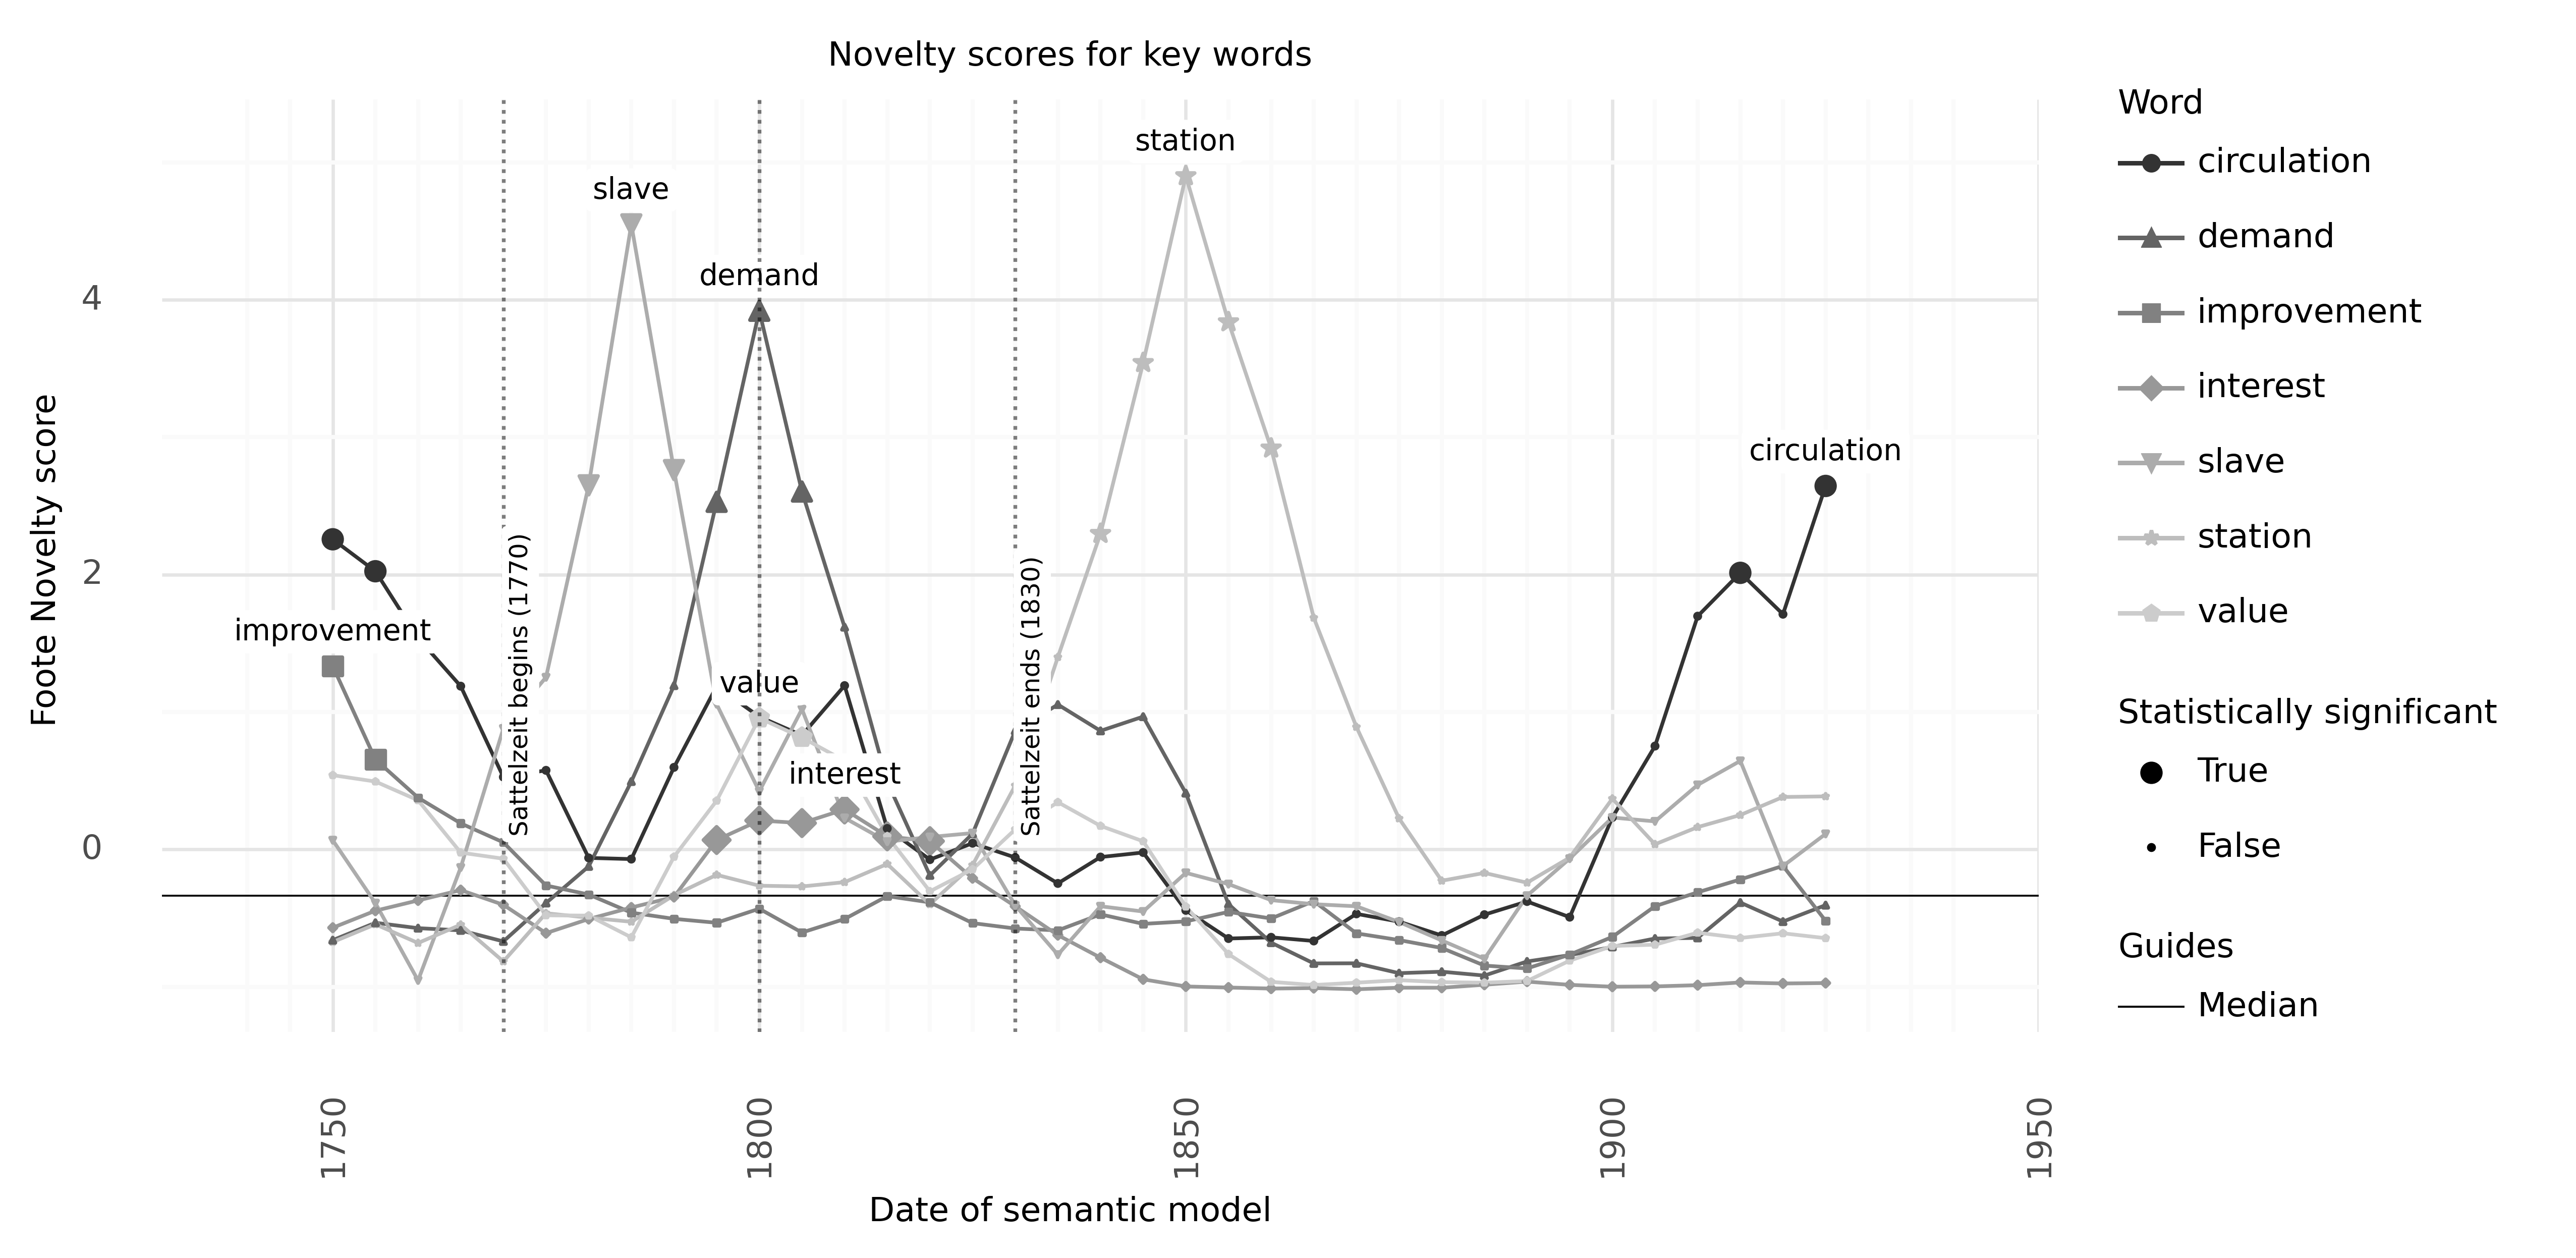

<ggplot: (8771716727617)>

In [108]:
# plot_novelty_words('station,value,commerce,growth,culture,slave,slavery,god,time,december')
plot_novelty_words('station,value,slave,demand,interest,circulation,improvement')